### Below used for debugging individual circuit runs


In [18]:
from qiskit.circuit.library import QuantumVolume, EfficientSU2, TwoLocal, QFT
from qiskit import QuantumCircuit
from qiskit.circuit.library.standard_gates import iSwapGate, CXGate
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.transpiler.coupling import CouplingMap
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate
import logging
from mirror_gates.pass_managers import SabreMS, QiskitLevel3
from transpile_benchy.metrics.depth_metric import DepthMetric, TotalMetric
from mirror_gates.utilities import FastConsolidateBlocks
from qiskit.transpiler.passes import Collect2qBlocks, Unroll3qOrMore, ConsolidateBlocks
from qiskit.transpiler import PassManager
import numpy as np

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
# transpile_benchy_logger.setLevel(logging.INFO)
transpile_benchy_logger.setLevel(logging.WARNING)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [19]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(7)
# coupling_map.draw()

In [20]:
# 2Q Gate Costs:
# CX: {CX:1, sqiswap:2}
# qc = TwoLocal(
#     num_qubits=N,
#     rotation_blocks="ry",
#     entanglement_blocks=CXGate(),
#     entanglement="full",
#     reps=1,
# )

# # CPHASE(pi/2): {CX:2, sqiswap:2}
# qc = TwoLocal(num_qubits=4,  rotation_blocks='ry', entanglement_blocks = CXGate().power(1/2), entanglement='full', reps=2)

# # iswap: {CX:2, sqiswap:2}
# qc = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks = iSwapGate(), entanglement='full', reps=2)

# # ECP: {CX:3, sqiswap:2}
# ecp = UnitaryGate(canonical_gate(0.5, 0.25, 0.25).full())
# qc = TwoLocal(
#     num_qubits=4,
#     rotation_blocks="ry",
#     entanglement_blocks=ecp,
#     entanglement="full",
#     reps=1,
# )

# SqiSwap: {CX:2, sqiswap:1}
# qc = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks= iSwapGate().power(1/2), entanglement='full', reps=2)

# qc = QFT(4)

# qc = QuantumCircuit(3)
# qc.ccx(0,1,2)
# qc.cx(0,1)
# qc.cx(0,2)

# qc.decompose().draw("mpl", fold=-1)

In [21]:
# # from qiskit import qft
# from qiskit.circuit.library import QFT

# qc = QFT(N)

In [22]:
from transpile_benchy.interfaces.abc_interface import MQTBench

filter_list = ["\\bqaoa"]  # , "grover-v-chain", " "\\bvqe",
# filter_list = ["ghz"]
# filter_list = None
mqt_bench = MQTBench(num_qubits=N, filter_list=filter_list)
qc = next(mqt_bench.get_quantum_circuits())

In [23]:
# from transpile_benchy.interfaces.qasm_interface import QASMBench

# coupling_map = CouplingMap.from_grid(6, 6)
# filter_list = ["seca_n11"]
# qasm_bench_m = QASMBench(size="medium", filter_list=filter_list)
# qc = next(qasm_bench_m.get_quantum_circuits())

In [24]:
# from qiskit.algorithms.minimum_eigensolvers import QAOA
# from qiskit.algorithms.optimizers import SLSQP
# from qiskit.primitives import Sampler
# from mqt.bench.utils import get_examplary_max_cut_qp
# num_qubits = N
# qp = get_examplary_max_cut_qp(num_qubits)
# qaoa = QAOA(sampler=Sampler(), reps=2, optimizer=SLSQP(maxiter=25))
# qaoa_result = qaoa.compute_minimum_eigenvalue(qp.to_ising()[0])
# qc = qaoa.ansatz.bind_parameters(qaoa_result.optimal_point)
# qc.name = "qaoa"

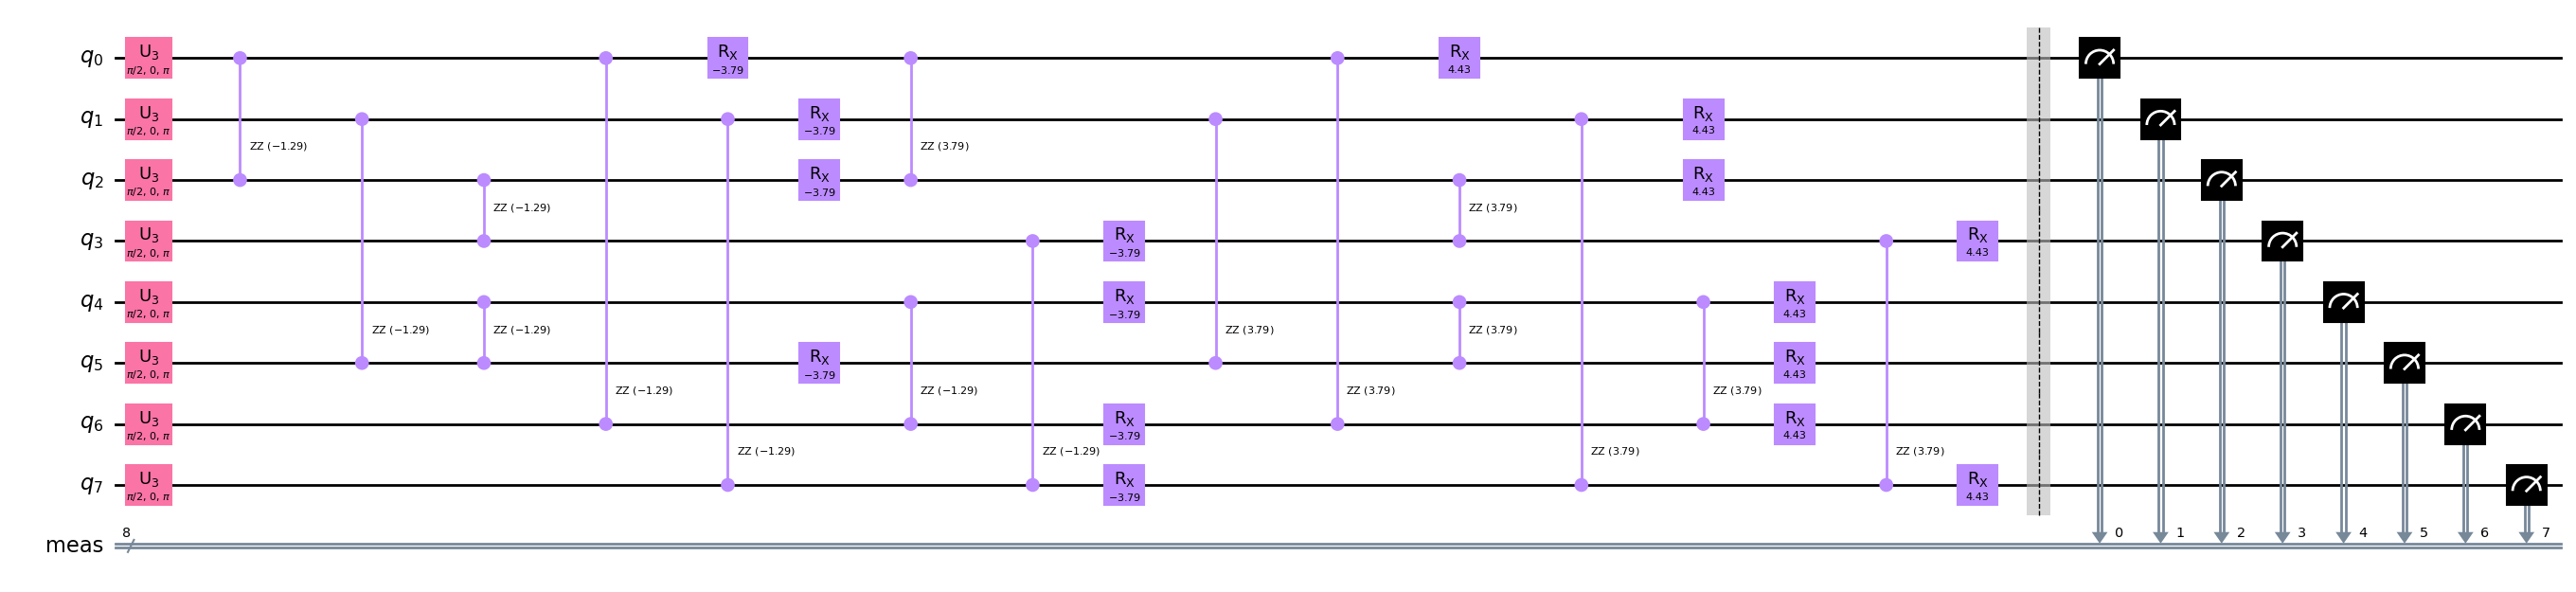

In [25]:
qc = qc.decompose().decompose()
qc.draw("mpl", fold=-1)

0.0
8.5


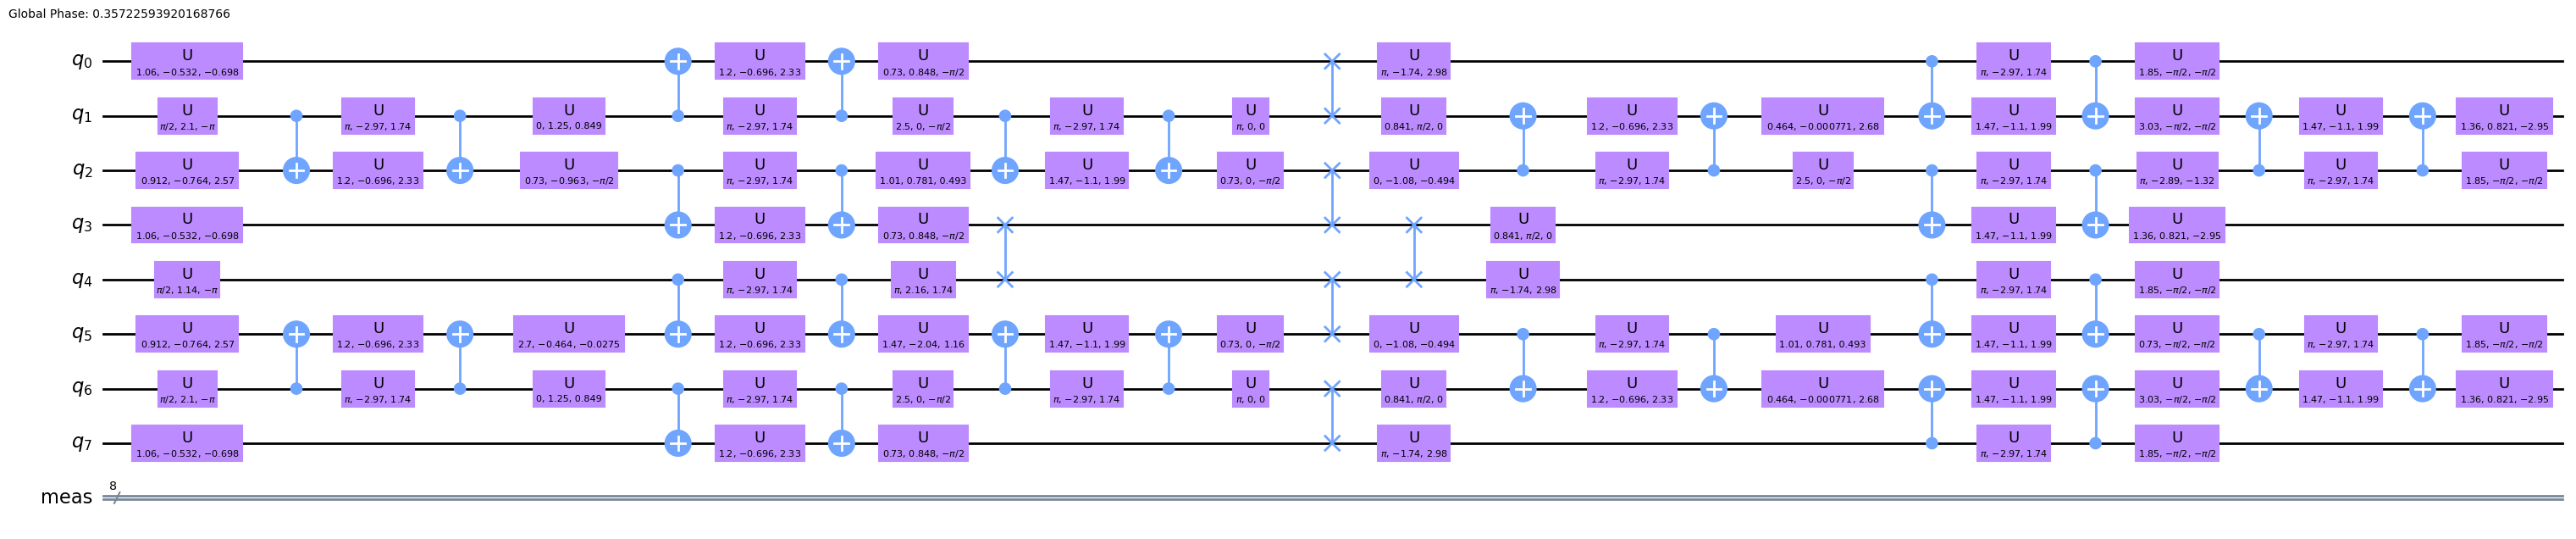

In [17]:
runner = SabreMS(
    coupling_map, cx_basis=0, parallel=False, logger=transpile_benchy_logger
)
metric = DepthMetric()
runner.append_metric_pass(metric)
metric = TotalMetric()
runner.append_metric_pass(metric)
runner.run(qc)
print(runner.property_set["accepted_subs"])
print(runner.property_set["monodromy_depth"])
# display(runner.property_set['pre'].draw('mpl'))
# display(runner.property_set["mid"].draw("mpl", fold=0))
# display(runner.property_set['post0'].draw('mpl'))
display(runner.property_set["post"].draw("mpl", fold=-1))
# display(transp.draw(output="mpl", fold=-1))

In [11]:
%load_ext snakeviz
import cProfile

# Profile 'your_function' and   write the result into 'my_profile.profile'
cProfile.run("runner.run(qc)", "my_profile7.prof")
# !snakeviz 'src/notebooks/my_profile.profile'

8.5


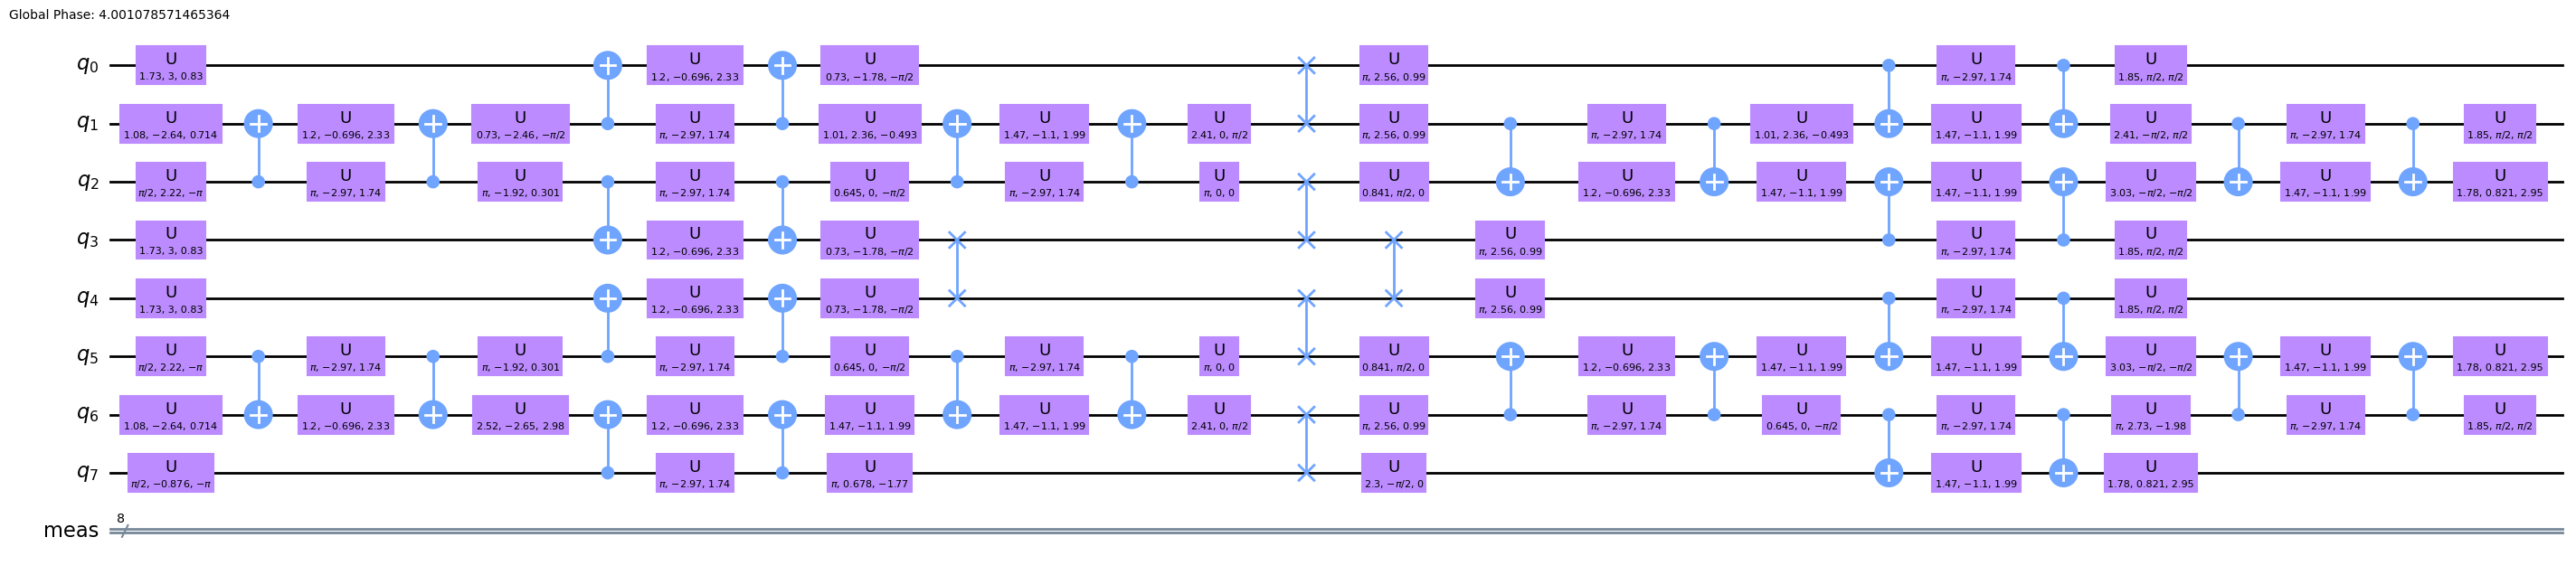

In [31]:
runner = QiskitLevel3(coupling_map, cx_basis=0)
metric = DepthMetric()
runner.append_metric_pass(metric)
transp = runner.run(qc)
print(runner.property_set["monodromy_depth"])
# display(transp.draw(output="mpl", fold=-1))
display(runner.property_set["post"].draw("mpl", fold=-1))

In [13]:
# qc = QuantumCircuit(2)
# qc.u(np.pi / 2, 0.394, 0, 0)
# qc.u(0.841, np.pi / 2, 0, 1)
# qc.cx(0, 1)
# qc.u(np.pi, -2.97, 1.74, 0)
# qc.u(1.42, -1.01, 2.07, 1)
# qc.cx(0, 1)
# qc.u(np.pi / 2, -np.pi / 2, 3, 0)
# qc.u(2.58, -2.67, 3.04, 1)
# display(qc.draw("mpl"))
# ##
# pm = PassManager([Unroll3qOrMore(), FastConsolidateBlocks(coord_caching=True)])
# # pm = PassManager([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
# cons_qc = pm.run(qc)
# cons_qc.draw("mpl", fold=-1)
# from weylchamber import c1c2c3

# [c1c2c3(instr.operation.to_matrix()) for instr in cons_qc]

In [14]:
# qc = QuantumCircuit(2)
# # qc.u(np.pi/2, 0.394, 0, 1)
# # qc.u(0,0,0, 1)
# qc.cx(0, 1)
# qc.u(np.pi, -2.97, 1.74, 0)
# qc.u(1.42, -1.01, 2.07, 1)
# qc.cx(0, 1)
# qc.u(0, 0, 0, 0)
# qc.u(2.58, -2.67, 3.04, 1)
# cons_qc = pm.run(qc)
# cons_qc.draw("mpl", fold=-1)
# from weylchamber import c1c2c3

# [c1c2c3(instr.operation.to_matrix()) for instr in cons_qc]